# Nuclear Reactor "Pincell" Example
In this example, we will demonstrate the creation of a simple 3D geometry. We will build a 3D "pincell" that is common in many pressurized water reactor geometries. It is basically a very long rectangular prism with a fuel cylinder runing through the middle of it lengthwise. The fuel cylinder is surrounded by a thin metal cladding region, with a very thin gap region between the fuel and the cladding. The area outside the cladding is the coolant. In this example, we will have the outer boundaries of the problems use a reflective boundary condition. The pincell will have the following dimensions:

Height = 300 cm

Pitch = 1.26 cm

Fuel Radius = 0.4096 cm

Inner Clad Radius = 0.4180 cm

Outer Clad Radius = 0.4750 cm

In [1]:
# Load the Library
using ConstructiveSolidGeometry

## 1 - Define Surfaces of the Problem

Let's start with the rectangular prism boundaries (i.e., 6 planes).

A **Plane** is defined by a point on the surface of the plane and the plane's unit normal vector. Both are specified in terms of a **Coord** object, which has three Float64 components x, y, and z corresponding to the vector's magnitude in each 3D cartesian direction.

We can also select a boundary condition to assign to that surface that the user will be notified of at each collision. By default if no condition is specified, a transmission boundary is used allowing for a ray to pass through the surface without changing direction. Reflective or vacuum boundaries can also be specified by passing strings as the last argument of the surface constructor. The package will automatically enforce reflective boundary conditions. Vacuum boundaries behave identically to transmission boundaries, though the user may wish to enforce some other physics on the ray when a vacuum is encountered (or terminate the ray altogether).

In [2]:
top =   Plane(Coord(0.0, 0.0, 150.0),  unitize(Coord(0.0, 0.0, 1.0)),  "reflective")
bot =   Plane(Coord(0.0, 0.0, -150.0), unitize(Coord(0.0, 0.0, -1.0)), "reflective")
left =  Plane(Coord(-.63, 0.0, 0.0),   unitize(Coord(-1.0, 0.0, 0.0)), "reflective")
right = Plane(Coord(0.63, 0.0, 0.0),   unitize(Coord(1.0, 0.0, 0.0)),  "reflective")
up =    Plane(Coord(0.0, 0.63, 0.0),   unitize(Coord(0.0, 1.0, 0.0)),  "reflective")
down =  Plane(Coord(0.0, -0.63, 0.0),  unitize(Coord(0.0, -1.0, 0.0)), "reflective");

Now let's specify the infinite cylinder that will form the structure of the fuel, gap, and cladding regions.

An **InfCylinder** is created by specifying a point along the central axis, the axial direction unit vector, and a radius. The point and directional vector are taken in the form of a **Coord** object. Note that these are transmission surfaces, as no boundary condition is specified.

In [3]:
clad_outer = InfCylinder(Coord(0.0, 0.0, 0.0), unitize(Coord(0.0, 0.0, 1.0)), 0.4750)
clad_inner = InfCylinder(Coord(0.0, 0.0, 0.0), unitize(Coord(0.0, 0.0, 1.0)), 0.4180)
fuel =       InfCylinder(Coord(0.0, 0.0, 0.0), unitize(Coord(0.0, 0.0, 1.0)), 0.4096);

## 2  - Define the Halfspace Regions of the Problem
Now we want to start building up our geometry using the surfaces we just defined. Each geometrical area, known as a **Cell**, is constructed logically out of any number of surfaces and their accompanying halfspaces. Surfaces divide all of space into two regions, positive and negative, according to the equation of the surface. For example, the negative halfspace of a sphere is the volume inside it, while the positive halfspace of a sphere is all space outside the sphere. We call each combination of a **Surface** and its halfspace sign a **Region**.

We will begin by creating an empty array of **Cell** objects to store the new cells as we make them. This will eventually hold the water, cladding, gap, and fuel cells of our geometry. We also create an empty array of **Region** objects to hold the halfspace regions that define the water cell.

In [4]:
cells = Array{Cell}(0)
regions = Array{Region}(0);

We begin by defining a set of regions which will be used to bound the water cell. A **Region** is defined as a surface and the sign of the halfspace that defines that region of space. I.e., a Region is created by a surface and a +1 or -1 integer. It is important to note that a plane may have two valid unit normals that are opposites of each other, but will affect the sign of the halfspace. Keep in mind that the (+) side of a plane's halfspace is on the side the normal points to.

In [5]:
push!(regions, Region(top, -1))
push!(regions, Region(bot, -1))
push!(regions, Region(left, -1))
push!(regions, Region(right, -1))
push!(regions, Region(up, -1))
push!(regions, Region(down, -1))
push!(regions, Region(clad_outer, 1));

# 3 - Define a Cell Using Logical Operators
Now we define the logical manner in which we can combine the above regions to create the volume of the cell. In this library, we can use the intersection operator **^**, the union operator **|**, and the complement operator **~**. We define this logical operation using a Julia expression, which is wrapped by :() to indicate that it is an expression. Here, our halfspaces are defined so that we just want the simple intersection of all the regions. The numbers we used to identify the regions are the same as their indices in the regions array we just created.

In [6]:
ex = :(1 ^ 2 ^ 3 ^ 4 ^ 5 ^ 6 ^ 7)

:(1 ^ (2 ^ (3 ^ (4 ^ (5 ^ (6 ^ 7))))))

With that done, we can create the water cell and push it to our cells array that we made earlier. A new **Cell** is made by specifying the array of regions and the logical expression that defines the cell.

In [7]:
push!(cells, Cell(regions, ex));

# 4 - Continue Making Cells
Now we do the same thing for the gap, cladding, and water regions

In [8]:
# Make the Cladding Cell
regions = Array{Region}(0)

push!(regions, Region(top, -1))
push!(regions, Region(bot, -1))
push!(regions, Region(clad_outer, -1))
push!(regions, Region(clad_inner, 1))

ex = :(1 ^ 2 ^ 3 ^ 4)

push!(cells, Cell(regions, ex))

# Make the Gap Cell
regions = Array{Region}(0)

push!(regions, Region(top, -1))
push!(regions, Region(bot, -1))
push!(regions, Region(clad_inner, -1))
push!(regions, Region(fuel, 1))

ex = :(1 ^ 2 ^ 3 ^ 4)

push!(cells, Cell(regions, ex))

# Make the Fuel Cell
regions = Array{Region}(0)

push!(regions, Region(top, -1))
push!(regions, Region(bot, -1))
push!(regions, Region(fuel, -1))

ex = :(1 ^ 2 ^ 3)

push!(cells, Cell(regions, ex));

# 5 - Store Cells In a Geometry Object
A **Geometry** object holds an array of cells and a bounding **Box** that defines the scope of our problem. A **Box** object is an axis aligned 3D box defined by its lower left (minimum) corner and its upper right (maximum) corner.

In [9]:
bounding_box = Box(Coord(-.63, -.63, -150), Coord(.63, .63, 150))

geometry = Geometry(cells, bounding_box);

# 6 - Plot a 2D Slice of the Geometry to Check Correctness
To make sure that our geometry looks as intended, we will take a 2D slice of the problem space and plot it. This can be accomplished using the function **plot_geometry_2D(geometry::Geometry, view::Box, dim::Int64)** which takes a **Geometry** object, a view, and the pixel dimension resolution of the plot. The view is a 2D box (in x and y) that defines what will be plotted. The z dimension should be the same for lower_left and upper_right, and represents where the slice is taken.


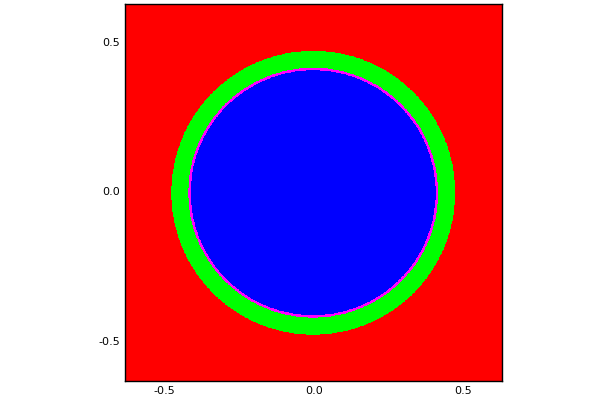

In [10]:
plot_geometry_2D(geometry, Box(Coord(-0.63, -0.63, 0), Coord(.63, 0.63, 0)), 1000)

We can also highlight a single cell within the geometry by using the function **plot_cell_2D(geometry::Geometry, view::Box, dim::Int64, cell_id::Int64)**, which is similar in function to the plot_geometry_2D() function, but also takes an additional argument indicating which cell to plot in black. Below, we plot the cladding cell.


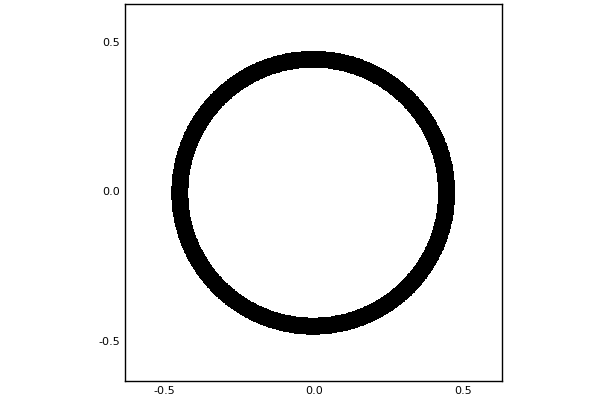

In [11]:
plot_cell_2D(geometry, Box(Coord(-0.63, -0.63, 0), Coord(.63, 0.63, 0)), 1000, 2)

# 6 - Begin Ray Tracing
At this point, we have a complete **Geometry** object that we can use to perform computations with. Let's test it by performing a standard ray trace operation. We utilize the generate_random_ray function to generate a **Ray** of random direction whose origin is uniformly distributed within a bounding box. 

In [12]:
ray = generate_random_ray(geometry.bounding_box);

We can then find the point where the ray will intersect with next using the find_intersection function. This function returns a new **Ray** object that is at the location where the intersection occurs and with the updated direction if a reflection occured. The location has already been "nudged" slightly so that when the ray is next evaluated it will not result in an unpredictable evaluation due to the origin still being within machine precision distance of a surface. The function also returns the id of the surface that it intersected with as well as the boundary criteria of that surface. This is useful as in some cases one may wish to act upon the ray when it hits a reflective or vacuum boundary condition.

In [13]:
# Perform a single step of ray tracing on the geometry
new_ray, id, boundary_type = find_intersection(ray, geometry)

# Compute distance travelled by the ray
distance = magnitude( new_ray.origin - ray.origin )

println("Ray moved ", distance, " [cm] before hitting a ", boundary_type, " boundary")

Ray moved 0.06004697964739698 [cm] before hitting a transmission boundary
